# Analyze training results of LoRA models with fictional dataset

In [475]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json

In [476]:
# Select result dirs to analyze

res_dir='results/1025random16' # random parameter search with 7b model
res_dir='results/1026optuna16' # optuna parameter search with 7b model
#res_dir="results/1027_2comp_models_n_lit"  # change number of target texts
#res_dir="results/1027_2comp_models_n_lit_full" # full lora layers
#res_dir="results/1027_3comp_models_n_irr" # change number of irrelevant texts
res_dir="results/1027_3comp_models_n_irr_full" # full lora layers


2


In [ ]:
json_files = glob.glob(res_dir+'/*.json')
print(len(json_files))
res_list=[]
for json_file in json_files:
    res_list.extend(json.load(open(json_file)))

In [477]:

for res in res_list:
    keys=res["lola_layer_dict"]

    for k,v in keys.items():
        if v:
            res[f"{k}"]=1
        else:
            res[f"{k}"]=0
    keys=res["train_context_dict"]
    for k,v in keys.items():
        if v:
            res[f"C{k}"]=1
        else:
            res[f"C{k}"]=0

In [478]:
df=pd.DataFrame(res_list)
df = df.select_dtypes(include=['number'])
cols = [col for col in df if col != 'score'] + ['score']
del_columns=[
'per_device_train_batch_size',
"total_epochs",
]
for c in del_columns:
    cols.remove(c) 
df = df[cols]
cols.remove('score')
df=df.drop_duplicates(subset=cols)
df=df.sort_values(by='score',ascending=False)

if "bit" not in df.columns:
    df["bit"]=4

df["bit"].fillna(4,inplace=True)

print(df.shape)
df[df["n_irrelevant_texts"]>1000][:5]
df.columns

(18, 31)


Index(['bit', 'n_irrelevant_texts', 'r', 'lr', 'lora_alpha', 'inner_epochs',
       'n_lit', 'model_size', 'epoch', 'embed_tokens', 'lm_head', 'q_proj',
       'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'C1',
       'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12',
       'score'],
      dtype='object')

In [479]:
#sns.set_style("whitegrid")
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [6, 6]
sns.set_palette("muted")
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

Text(0.5, 0, 'Correlation with score')

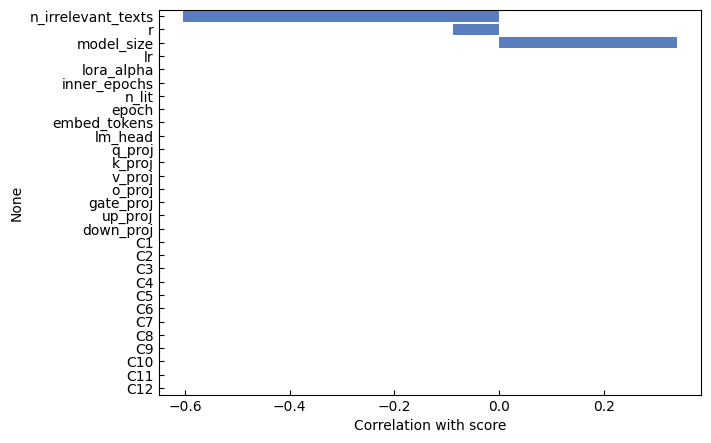

In [480]:

plt.rcParams['font.size'] = 10
plt.figure(figsize=(7,5))
score_df=df.corr()["score"].drop(["score","bit"]).sort_values()
sns.barplot(x=score_df.values,y=score_df.index)
plt.xlabel("Correlation with score")

In [481]:
df.to_csv("fic_optuna.csv")

Text(63.08333333333333, 0.5, '')

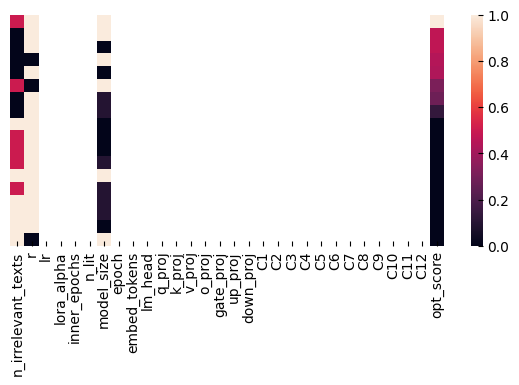

In [482]:
normalized_df =df.copy()

normalized_df["opt_score"]=normalized_df["score"]*np.log10(normalized_df["n_irrelevant_texts"])
log_labels=[
"epoch",
"r",
"lr",
"lora_alpha",
"n_irrelevant_texts",
]

normalized_df=normalized_df.sort_values("opt_score",ascending=False).drop(["bit","score"],axis=1)

for l in log_labels:
    normalized_df[l]=np.log10(normalized_df[l])
normalized_df=(normalized_df - normalized_df.min()) / (normalized_df.max() - normalized_df.min())

plt.rcParams['font.size'] = 10
plt.figure(figsize=(7,3))
ax=sns.heatmap(normalized_df[:])
ax.set_yticklabels([])
ax.yaxis.set_ticks_position('none')
#plt.xticks(fontsize=6)
plt.yticks()
plt.ylabel("")

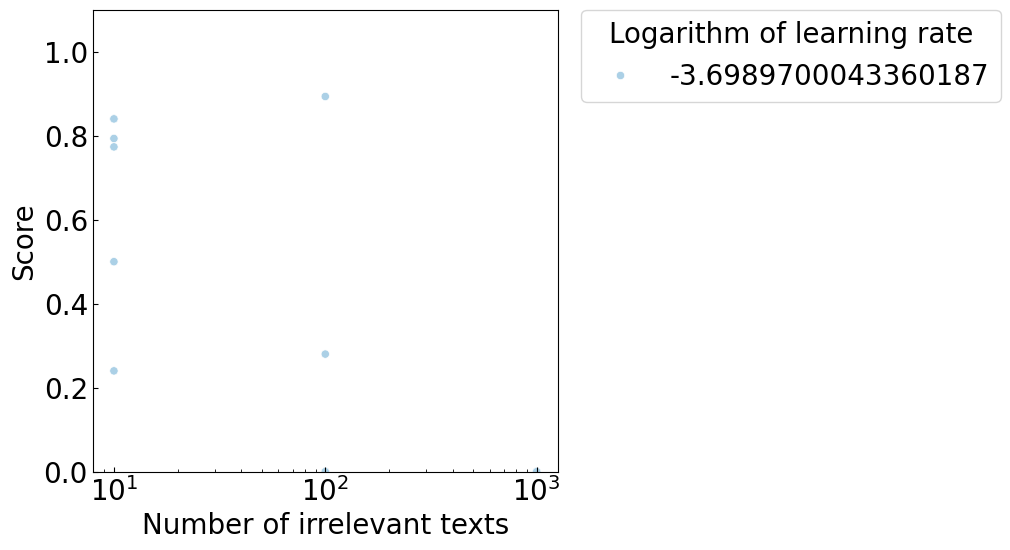

In [483]:

plt.rcParams['font.size'] = 20

plt_df=df.copy()
plt_df["log_lr"]=np.log10(plt_df["lr"])
#sns.scatterplot(data=plt_df,x="n_irrelevant_texts",y="score",hue="epoch")
sns.scatterplot(data=plt_df,x="n_irrelevant_texts",y="score",hue="log_lr",palette="Blues_d")
plt.xscale("log")

plt.ylim(0,1.1)
plt.xlabel("Number of irrelevant texts")
plt.ylabel("Score")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,title="Logarithm of learning rate")

In [484]:
import numpy as np
from sklearn.linear_model import LinearRegression
plt_df=df.copy()
plt_df=plt_df[plt_df["score"]>0.5]
mean_df=plt_df.groupby(by="n_irrelevant_texts").max().reset_index()

x=mean_df["n_irrelevant_texts"]
y=mean_df["lr"]
logx=np.array(np.log10(x)).reshape(-1,1)
logy=np.array(np.log10(y)).reshape(-1,1)

"""
reg=LinearRegression()
reg.fit(logx,logy)
pred_y=reg.predict(logx)
mean_df["regression"]=10**pred_y

plt.scatter(mean_df["n_irrelevant_texts"],mean_df["lr"])
plt.plot(mean_df["n_irrelevant_texts"],mean_df["regression"],c="gray")


plt.xscale("log")
plt.yscale("log")
plt.xlim(10,5000)
plt.xlabel("Number of irrelevant texts")
plt.ylabel("Learning rate")
reg.coef_,reg.intercept_
"""

'\nreg=LinearRegression()\nreg.fit(logx,logy)\npred_y=reg.predict(logx)\nmean_df["regression"]=10**pred_y\n\nplt.scatter(mean_df["n_irrelevant_texts"],mean_df["lr"])\nplt.plot(mean_df["n_irrelevant_texts"],mean_df["regression"],c="gray")\n\n\nplt.xscale("log")\nplt.yscale("log")\nplt.xlim(10,5000)\nplt.xlabel("Number of irrelevant texts")\nplt.ylabel("Learning rate")\nreg.coef_,reg.intercept_\n'

In [485]:
10**(-0.38*np.log10(5000)-2.37)

0.00016764530618725815

/tmp/ipykernel_1895139/423046422.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=plt_df,x="n_irrelevant_texts",y="score",palette="Blues_d")


Text(0, 0.5, 'Score')

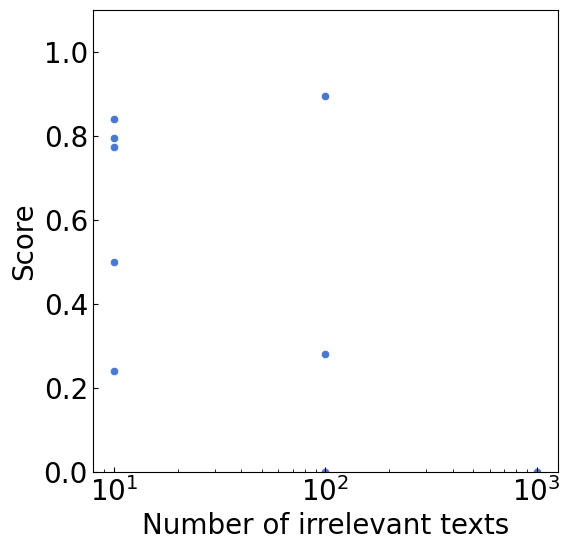

In [486]:


plt.rcParams['font.size'] = 20

plt_df=df.copy()
plt_df["log_lr"]=np.log10(plt_df["lr"])
#sns.scatterplot(data=plt_df,x="n_irrelevant_texts",y="score",hue="epoch")
sns.scatterplot(data=plt_df,x="n_irrelevant_texts",y="score",palette="Blues_d")
plt.xscale("log")

plt.ylim(0,1.1)
plt.xlabel("Number of irrelevant texts")
plt.ylabel("Score")
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,title="Logarithm of learning rate")

Text(0, 0.5, 'Score')

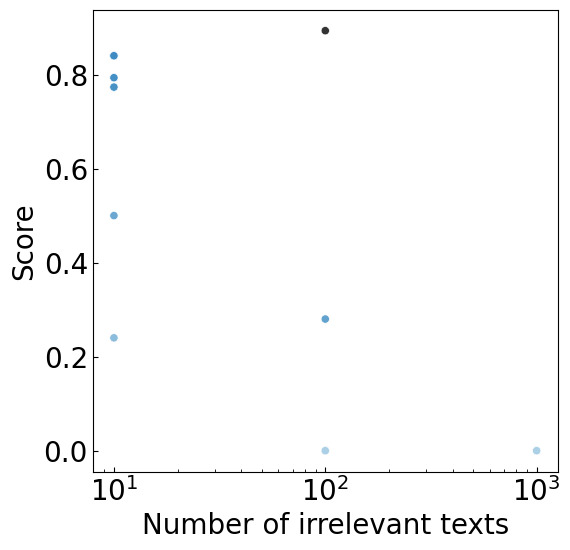

In [487]:
plt_df["opt_score"]=plt_df["score"]*np.log10(plt_df["n_irrelevant_texts"])
ax=sns.scatterplot(data=plt_df,x="n_irrelevant_texts",y="score",hue="opt_score",palette="Blues_d")
plt.xscale("log")

ax.legend_.remove() 
#legendは非表示にしたい
plt.xlabel("Number of irrelevant texts")
plt.ylabel("Score")


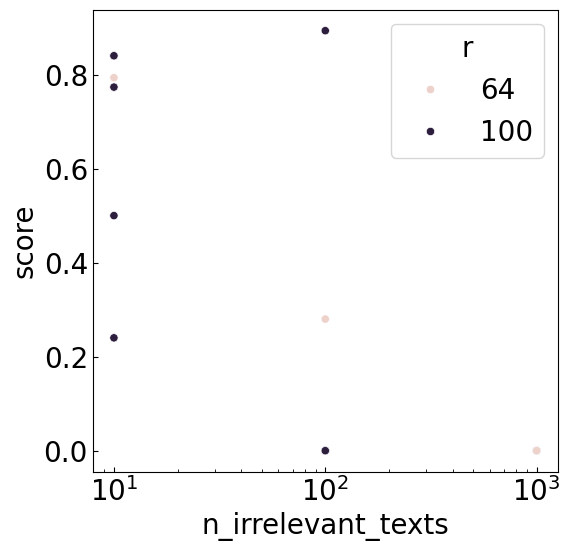

In [488]:

sns.scatterplot(data=plt_df,x="n_irrelevant_texts",y="score",hue="r")

plt.xscale("log")

(0.0, 1.1)

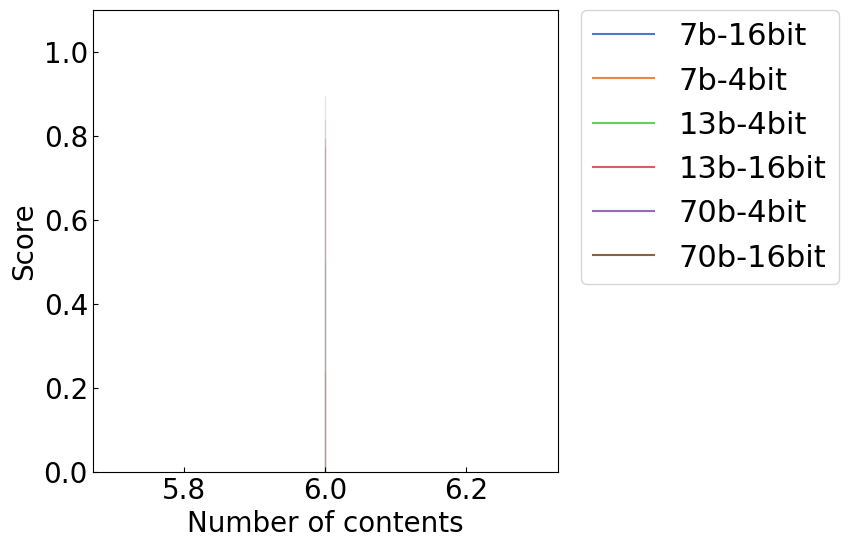

In [489]:
plt_df=df.copy()
plt_df=plt_df.sort_values(by=["model_size"])
plt_df["model_cond"]=plt_df["model_size"].astype(str)+"b-"+plt_df["bit"].astype(str)+"bit"
plt_df["n_lit"]+=1
ax=sns.lineplot(data=plt_df,x="n_lit",y="score",hue="model_cond")

plt.legend(title="",bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=22)
#ax.legend_.remove() 
plt.xlabel("Number of contents")
plt.ylabel("Score")
plt.ylim(0,1.1)

In [490]:
plt_df

,bit,n_irrelevant_texts,r,lr,lora_alpha,inner_epochs,n_lit,model_size,epoch,embed_tokens,...,C5,C6,C7,C8,C9,C10,C11,C12,score,model_cond
18,16,1000,100,0.0002,300,10,6,7,1,1,...,1,0,0,0,0,0,0,0,0.000000,7b-16bit
0,4,10,100,0.0002,300,10,6,7,1,1,...,1,0,0,0,0,0,0,0,0.840000,7b-4bit
12,16,100,100,0.0002,300,10,6,7,1,1,...,1,0,0,0,0,0,0,0,0.000000,7b-16bit
1,16,10,100,0.0002,300,10,6,7,1,1,...,1,0,0,0,0,0,0,0,0.773333,7b-16bit
17,4,1000,100,0.0002,300,10,6,7,1,1,...,1,0,0,0,0,0,0,0,0.000000,7b-4bit
11,4,100,100,0.0002,300,10,6,7,1,1,...,1,0,0,0,0,0,0,0,0.000000,7b-4bit
13,4,100,100,0.0002,300,10,6,13,1,1,...,1,0,0,0,0,0,0,0,0.000000,13b-4bit
2,4,10,100,0.0002,300,10,6,13,1,1,...,1,0,0,0,0,0,0,0,0.500000,13b-4bit
3,16,10,100,0.0002,300,10,6,13,1,1,...,1,0,0,0,0,0,0,0,0.240000,13b-16bit
14,16,100,100,0.0002,300,10,6,13,1,1,...,1,0,0,0,0,0,0,0,0.000000,13b-16bit


(0.0, 1.1)

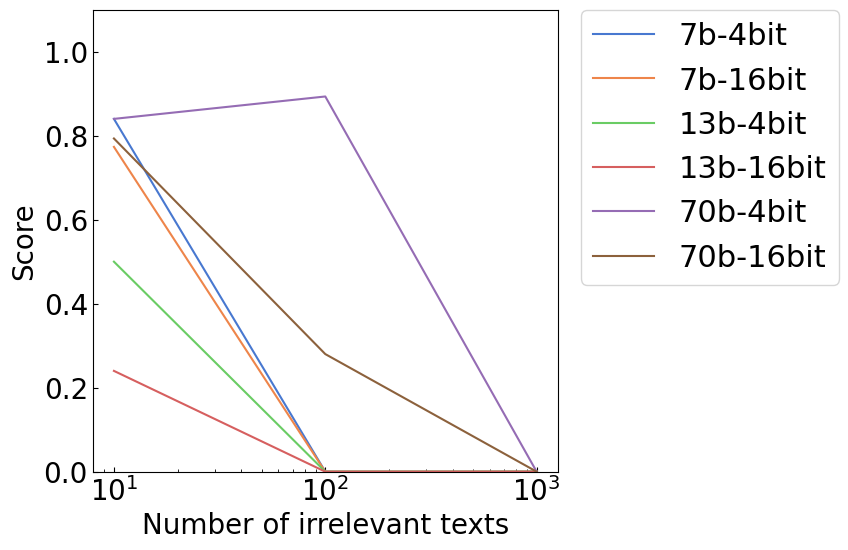

In [491]:

plt_df=df.copy()
plt_df=plt_df.sort_values(by=["model_size","bit"]).reset_index(drop=True)
plt_df["model_cond"]=plt_df["model_size"].astype(str)+"b-"+plt_df["bit"].astype(str)+"bit"
ax=sns.lineplot(data=plt_df,x="n_irrelevant_texts",y="score",hue="model_cond")

plt.xscale("log")

plt.legend(title="",bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=22)
plt.xlabel("Number of irrelevant texts")
plt.ylabel("Score")
plt.ylim(0,1.1)

In [492]:
plt_df

,bit,n_irrelevant_texts,r,lr,lora_alpha,inner_epochs,n_lit,model_size,epoch,embed_tokens,...,C5,C6,C7,C8,C9,C10,C11,C12,score,model_cond
0,4,10,100,0.0002,300,10,5,7,1,1,...,1,0,0,0,0,0,0,0,0.840000,7b-4bit
1,4,1000,100,0.0002,300,10,5,7,1,1,...,1,0,0,0,0,0,0,0,0.000000,7b-4bit
2,4,100,100,0.0002,300,10,5,7,1,1,...,1,0,0,0,0,0,0,0,0.000000,7b-4bit
3,16,10,100,0.0002,300,10,5,7,1,1,...,1,0,0,0,0,0,0,0,0.773333,7b-16bit
4,16,1000,100,0.0002,300,10,5,7,1,1,...,1,0,0,0,0,0,0,0,0.000000,7b-16bit
5,16,100,100,0.0002,300,10,5,7,1,1,...,1,0,0,0,0,0,0,0,0.000000,7b-16bit
6,4,10,100,0.0002,300,10,5,13,1,1,...,1,0,0,0,0,0,0,0,0.500000,13b-4bit
7,4,1000,100,0.0002,300,10,5,13,1,1,...,1,0,0,0,0,0,0,0,0.000000,13b-4bit
8,4,100,100,0.0002,300,10,5,13,1,1,...,1,0,0,0,0,0,0,0,0.000000,13b-4bit
9,16,10,100,0.0002,300,10,5,13,1,1,...,1,0,0,0,0,0,0,0,0.240000,13b-16bit
